In [1]:
from __future__ import print_function

from sqlalchemy import create_engine, Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql import exists

import datetime
import numpy as np
import glob

from multiprocessing import Pool

## Boilerplate path hack to give access to full clustered_SNe package
import os,sys
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))
        

from clustered_SNe.analysis.constants import m_proton, pc, yr, M_solar, \
                                   metallicity_solar
from clustered_SNe.analysis.parse import Overview, parse_run, \
                                         Inputs



/Users/egentry/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


#### Helpful resource:
http://docs.sqlalchemy.org/en/latest/orm/tutorial.html

In [2]:
engine = create_engine('sqlite:///clustered_SNe.db')
Base = declarative_base()
class Simulation(Base):
    __tablename__ = "simulations"
    id = Column(String, primary_key = True)
    data_dir = Column(String)
    
    metallicity = Column(Float)
    background_density = Column(Float)
    background_temperature = Column(Float)
    with_cooling = Column(Integer)
    cooling_type = Column(String)
    num_SNe = Column(Integer)
    cluster_mass = Column(Float)
    seed = Column(Integer)
    mass_loss = Column(String)
    
    E_R_kin = Column(Float)
    E_R_int = Column(Float)
    M_R     = Column(Float)
    R       = Column(Float)
    t       = Column(Float)
    momentum = Column(Float)
    num_checkpoints = Column(Integer)
    
    last_updated = Column(String)
    
    def __repr__(self):
        return "<Simulation: {0}, last updated: {1}".format(self.id, self.last_updated)
    
class Simulation_Inputs(Base):
    __tablename__ = "inputs"
    id = Column(String, primary_key = True)
    
    T_Start = Column(Float)
    T_End = Column(Float)
    Num_Reports = Column(Integer)
    Num_Checkpoints = Column(Integer)
    Use_Logtime = Column(Integer)
    
    Num_R = Column(Integer)
    R_Min = Column(Float)
    R_Max = Column(Float)
    Log_Zoning = Column(Integer)
    Log_Radius = Column(Integer)
    
    CFL = Column(Integer)
    PLM = Column(Integer)
    RK2 = Column(Integer)
    H_0 = Column(Float)
    H_1 = Column(Float)
    Riemann_Solver = Column(Integer)
    Density_Floor = Column(Float)
    Pressure_Floor = Column(Float)
    
    With_Cooling = Column(Integer)
    Cooling_Type = Column(String)
    Adiabatic_Index = Column(Float)
    
    ICs = Column(String)
    mass_loss = Column(String)
    
    def __repr__(self):
        return "<Inputs for id: {0}>".format(self.id)
    
    def from_Inputs(id, inputs):
        
        simulation_inputs = Simulation_Inputs(id=id,
            T_Start         = inputs.T_Start,
            T_End           = inputs.T_End,
            Num_Reports     = inputs.Num_Reports,
            Num_Checkpoints = inputs.Num_Checkpoints,
            Use_Logtime     = inputs.Use_Logtime,

            Num_R = inputs.Num_R,
            R_Min = inputs.R_Min,
            R_Max = inputs.R_Max,
            Log_Zoning = inputs.Log_Zoning,
            Log_Radius = inputs.Log_Radius,

            CFL = inputs.CFL,
            PLM = inputs.PLM,
            RK2 = inputs.RK2,
            H_0 = inputs.H_0,
            H_1 = inputs.H_1,
            Riemann_Solver  = inputs.Riemann_Solver,
            Density_Floor   = inputs.Density_Floor,
            Pressure_Floor  = inputs.Pressure_Floor,

            With_Cooling = inputs.With_Cooling,
            Cooling_Type = inputs.Cooling_Type,

            Adiabatic_Index = inputs.Adiabatic_Index,

            ICs         = inputs.ICs,

            mass_loss   = inputs.mass_loss,
        )
        return simulation_inputs
        
    
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()
    

In [10]:
class Momentum_Surface_Point(object):
    def __init__(self, simulation):
        self.mass = simulation.cluster_mass
        self.momentum = simulation.momentum
        self.density = simulation.background_density
        self.metallicity = simulation.metallicity
        self.id = simulation.id

In [3]:
def simulation_from_last_run(data_dir, last_run):
    id = last_run["id"]

    metallicity             = last_run["overview"].metallicity
    background_density      = last_run["overview"].background_density
    background_temperature  = last_run["overview"].background_temperature
    with_cooling            = last_run["overview"].with_cooling
    cooling_type            = last_run["overview"].cooling_type
    num_SNe                 = last_run["overview"].num_SNe
    cluster_mass            = last_run["overview"].cluster_mass
    seed                    = last_run["overview"].seed
    mass_loss               = last_run["overview"].mass_loss
    
    extraction_index = np.argmax(last_run["momentum"])

    E_R_kin = last_run["E_R_kin"][extraction_index]
    E_R_int = last_run["E_R_int"][extraction_index]
    M_R     = last_run["M_R"][extraction_index]
    R       = last_run["R_shock"][extraction_index]

    t       = last_run["times"][extraction_index]
    momentum = last_run["momentum"][extraction_index]
    num_checkpoints = len(last_run["filenames"])

    last_updated = str(datetime.datetime.now())

    simulation = Simulation(id=id, data_dir=data_dir,
                            metallicity             = metallicity,
                            background_density      = background_density,
                            background_temperature  = background_temperature,
                            with_cooling            = with_cooling,
                            cooling_type            = cooling_type,
                            num_SNe                 = num_SNe,
                            cluster_mass            = cluster_mass, 
                            seed                    = seed,
                            mass_loss               = mass_loss, 
                            E_R_kin = E_R_kin,
                            E_R_int = E_R_int,
                            M_R     = M_R,
                            R       = R,
                            t       = t,
                            momentum = momentum,
                            num_checkpoints = num_checkpoints,
                            last_updated = last_updated)
    return simulation



def add_simulation(simulation, simulation_inputs):
    session.add(simulation)
    session.add(simulation_inputs)

def update_simulation(simulation):
    # Only updates the things I *think* are going to change
    # things like cluster mass *shouldn't* change, 
    # but if you did change that, things could break
    session.query(Simulation).\
        filter(Simulation.id==simulation.id).\
        update({
            "E_R_kin": simulation.E_R_kin,
            "E_R_int": simulation.E_R_int,
            "M_R":     simulation.M_R,
            "R":       simulation.R,
            "t":       simulation.t,
            "momentum": simulation.momentum,
            "num_checkpoints": simulation.num_checkpoints,
            "last_updated": simulation.last_updated
        })


def add_or_update_simulation(simulation, simulation_inputs):
    # I should probably check that the counts 
    count = session.query(Simulation).\
        filter(Simulation.id==simulation.id).\
        count()

    count_tmp = session.query(Simulation_Inputs).\
        filter(Simulation_Inputs.id==simulation_inputs.id).\
        count()
        
    if count != count_tmp:
        raise RuntimeError("SQL tables aren't consistent about simulations")
        
    if count == 0:
        add_simulation(simulation, simulation_inputs)
    elif count == 1:
        update_simulation(simulation)
    else:
        print("count: ", count)
        raise RuntimeError("id seems non-unique?")
        
        

def parse_into_simulations(data_dir_and_id):
    # wrapper function to allow multiprocessing + map
    data_dir, id = data_dir_and_id
    last_run = parse_run(data_dir, id)
    simulation = simulation_from_last_run(data_dir, last_run)
    
    inputs = Inputs(os.path.join(data_dir, id + "_inputs.dat"))
    simulation_inputs = Simulation_Inputs.from_Inputs(id, inputs)
    return simulation, simulation_inputs
        

In [11]:
for sim in session.query(Simulation):
    print(sim)

<Simulation: 000c7c73-33da-42e3-9b87-d2e61a386d08, last updated: 2015-11-23 15:41:51.198663
<Simulation: 016530ff-83c1-4200-9b95-96a06c1a3957, last updated: 2015-11-23 15:42:14.929358
<Simulation: 05219c9a-2fb3-4943-813f-5dea43c1f822, last updated: 2015-11-23 15:43:09.784470
<Simulation: 069a31c0-ff00-4a69-a320-f734877d732b, last updated: 2015-11-23 15:43:35.262786
<Simulation: 073b72de-970e-4f09-96dd-708e27688e95, last updated: 2015-11-23 15:44:11.745075
<Simulation: 0ba8b023-c555-45c9-8fb2-dd7a4c6da1e6, last updated: 2015-11-23 15:44:46.640284
<Simulation: 0ca1a191-8aae-4577-a233-7926a6ab7e02, last updated: 2015-11-23 15:44:58.664802
<Simulation: 0df337f0-6afa-496d-8eea-8e75f6a0bea5, last updated: 2015-11-23 15:45:33.077486
<Simulation: 0e13dae0-7ed9-4798-a158-63e9cba63636, last updated: 2015-11-23 15:46:04.280880
<Simulation: 0e558316-efa9-4259-a48c-eea876c7d618, last updated: 2015-11-23 15:46:17.237779
<Simulation: 0fcb725a-9abb-4702-9c0c-5531e1ffab62, last updated: 2015-11-23 15:4

In [5]:
for sim_inputs in session.query(Simulation_Inputs):
    print(sim_inputs)

In [6]:
def add_entire_dir_to_database(data_dir):
    overview_filenames = glob.glob(os.path.join(data_dir, "*overview.dat"))
    ids = [None]*len(overview_filenames)
    for k, filename in enumerate(overview_filenames):
        ids[k] = os.path.basename(filename).split("_overview.dat")[0]
#     print(ids)

    mappable_inputs = [(data_dir, id) for id in ids]
    
    pool = Pool(4)
    simulation_tuples = pool.map(parse_into_simulations, mappable_inputs)
    for simulation, simulation_inputs in simulation_tuples:
        add_or_update_simulation(simulation, simulation_inputs)

add_entire_dir_to_database("../saved_runs/cluster_parameter_study_new")

In [ ]:
session.commit()

In [15]:
session.close()

# Use the database

In [12]:
points = []

for simulation in session.query(Simulation):
    point = Momentum_Surface_Point(simulation)
    points.append(point)

In [13]:
momenta = [point.momentum for point in points if (point.metallicity==metallicity_solar)]
masses = [point.mass for point in points if (point.metallicity==metallicity_solar)]
densities = [point.density for point in points if (point.metallicity==metallicity_solar)]

momenta = np.array(momenta)
masses = np.array(masses)
densities = np.array(densities)

momenta = momenta / masses / 1e5
masses = masses / M_solar
densities

masses_set = set()
for mass in masses:
    masses_set.add(mass)

density_set = set()
for density in densities:
    density_set.add(density)
    
masses_1D = np.sort(list(masses_set))
densities_1D = np.sort(list(density_set))

masses_2D, densities_2D = np.meshgrid(masses_1D, densities_1D) 

momenta_2D = np.empty_like(masses_2D)

for i,mass in enumerate(masses_1D):
    for j,density in enumerate(densities_1D):
        good_masses = (masses == mass)
        good_densities = (densities == density)
        good = good_masses & good_densities
        print("good momenta: ", momenta[good])
        print("mass: {0}   density:  {1}".format(mass, density))
        print()
        momenta_2D[j,i] = np.average(momenta[good])
    
momenta_2D[momenta_2D == 0] = 1

good momenta:  [  3.91638316e-11]
mass: 99.99999999999999   density:  2.224587e-27

good momenta:  [  2.65167321e-10]
mass: 99.99999999999999   density:  2.224587e-26

good momenta:  [  1.35027580e-10]
mass: 99.99999999999999   density:  2.224587e-25

good momenta:  [  5.53103904e-12]
mass: 99.99999999999999   density:  2.224587e-24

good momenta:  [ 10385.31481755]
mass: 99.99999999999999   density:  2.224587e-23

good momenta:  [ 11192.30285186]
mass: 99.99999999999999   density:  2.224587e-22

good momenta:  [ 7470.53499616]
mass: 99.99999999999999   density:  2.224587e-21

good momenta:  [ 14149.12226996]
mass: 1000.0   density:  2.224587e-27

good momenta:  [ 26954.26543858]
mass: 1000.0   density:  2.224587e-26

good momenta:  [ 22145.98313533]
mass: 1000.0   density:  2.224587e-25

good momenta:  [ 33759.68620868]
mass: 1000.0   density:  2.224587e-24

good momenta:  [ 57850.2726262]
mass: 1000.0   density:  2.224587e-23

good momenta:  [ 19617.05106325]
mass: 1000.0   density: 

/Users/egentry/anaconda/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


<IPython.core.display.Javascript object>


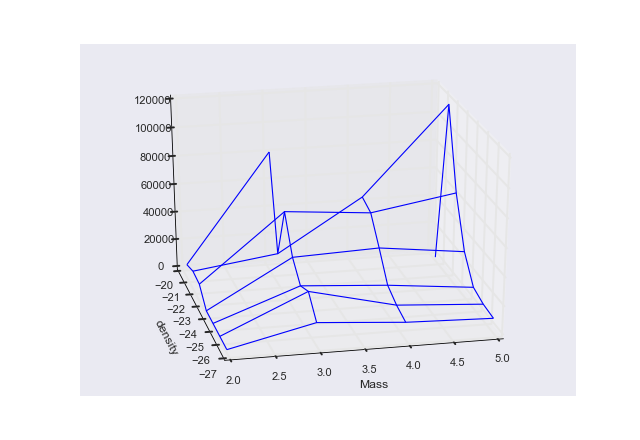

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_wireframe(np.log10(masses_2D), np.log10(densities_2D), momenta_2D, rstride=1, cstride=1,
                       linewidth=1)

plt.xlabel("Mass")
plt.ylabel("density")
# plt.show()